# Numerical integration


$$ \int_a^b \, f(x) dx = F(b) - F(a) $$

Key assumptions about integrand function $f(x)$: 

 1) evaluations are expensive

 2) approximately polynomial, at least locally


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.integrate

### Define some test functions, some with known integrals.

In [3]:
def func1(x):
    return x**5

def func2(x):
    return 1.0 / x

def func3(x):
    return 1.0 + 2.0*x - 0.2*x**2 + 1.0*np.sin(3*x)    

def int_func1(a,b):
    return (b**6 - a**6) / 6.0

def int_func2(a,b):
    return np.log(b) - np.log(a)

## Gaussian quadrature
https://en.wikipedia.org/wiki/Gaussian_quadrature


In numerical analysis, a quadrature rule is an approximation of the definite integral of a function, usually stated as a weighted sum of function values at specified points within the domain of integration. (See numerical integration for more on quadrature rules.) An n-point Gaussian quadrature rule, named after Carl Friedrich Gauss, is a quadrature rule constructed to yield an exact result for polynomials of degree 2n − 1 or less by a suitable choice of the points xi and weights wi for i = 1, ..., n. The domain of integration for such a rule is conventionally taken as [−1, 1], so the rule is stated as

$$ \int _{-1}^{1}f(x)\,dx=\sum _{i=1}^{n}w_{i} \,f(x_{i}) $$

In [4]:

xrange = [-1.0, 6.0]
quad_integral, error_estimate = scipy.integrate.quad( func3, xrange[0], xrange[1] )

### Trapezoidal rule

Evaluate the function at 10 locations (including the endpoints!) and then apply the trapezoidal rule to each of 9 intervals. We could loop over each pair of points, but numpy allows us to calculate with entire arrays

$$ \int_a^b f(x) dx \approx \frac{1}{2} \left[ f(b)+f(a) \right] \;\times\; (b-a)   $$



In [5]:
# Estimate integral using trapezoidal rule
#
#
x = np.linspace(0.0, 1.0, 10)
dx = x[1:] - x[0:-1]

y = func1(x)
ymean = (y[0:-1] + y[1:]) / 2.0
integral1 = np.sum( ymean * dx )

print('x:', x, '\n' )
print('y:', y, '\n' )
print('estimate: ', integral1, '\ntrue: ', int_func1(0,1), '\nerror: ', integral1-int_func1(0,1) )

x: [0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ] 

y: [0.00000000e+00 1.69350878e-05 5.41922810e-04 4.11522634e-03
 1.73415299e-02 5.29221494e-02 1.31687243e-01 2.84628021e-01
 5.54928957e-01 1.00000000e+00] 

estimate:  0.17179799827262104 
true:  0.16666666666666666 
error:  0.005131331605954387


If we're going to repeat this sequence of code more than once, then we should turn it into a function.

In [19]:
def integrate_trapz(a, b, npoints, integrand):
    """ this is a very short 'doc-string' """
    x = np.linspace(a, b, npoints)
    dx = x[1:] - x[0:-1]
    y = integrand(x)
    ymean = (y[0:-1] + y[1:]) / 2.0
    result = np.sum( ymean * dx )    
    return result

integral1 = integrate_trapz(0.0, 1.0, 10, integrand=func1)
print(integral1)
#print(integral1, int_func1(0,1), integral1 - int_func1(0,1) )
    

0.17179799827262104


Determine how the error changes as we increase the number of evaluation points

In [7]:
xa, xb = 0, 1
npointslist = [10, 20, 30, 40, 50]
result = []
for npoints in npointslist:
    integral1 = integrate_trapz(xa, xb, npoints, integrand=func1)
    result.extend( [npoints, integral1 - int_func1(xa, xb)] )
    
x = np.array( result[0::2] )    
y = np.array( result[1::2] )    

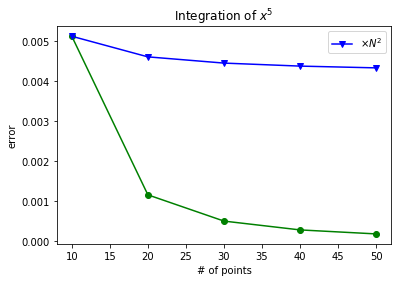

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot( x, y , 'go-', label = '')
plt.plot( x, y * (x/x[0])**2, 'bv-', label='$\\times N^2$' )  
plt.xlabel('# of points')
plt.ylabel('error')
plt.title('Integration of $x^5$')
plt.legend(loc=0)

It appears that the error is decreasing a little faster than $N^2$. Does this just mean that we increase the number of points until the error becomes small enough?

## Life is complicated


there are (at least) two problems

 0) roundoff-error

 1) waste of previous calculations

 2) don't usually know correct value, so can't know convergence

## Repeated reuse

Start by evaluating the function at 4 points (circles in the figure below) and apply the trapezoidal rule for each of the three intervals. Assume for a minute that we had some way to determine that the resulting estimate of the integral wasn't good enough. If we "zoom in" and use 7 points then 4 of them will be the same as the original ones, so we actually only need to evaluate at 3 points. If that isn't enough, then we can go to N=13, which only requires another 6 points.

This allows us to shrink to sucessively smaller intervals without wasting previous calculations.

(-0.1, 1.1)

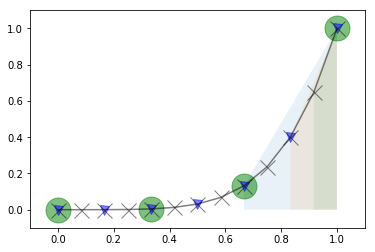

In [9]:
xa, xb = 0.0, 1.0
for npoints,symtype,symsize in zip([4,7,13], ['go', 'bv', 'kx-'], [25, 9, 15]):
    x = np.linspace(xa, xb, npoints)
    y = func1(x)
    plt.plot(x, y, symtype, ms=symsize, alpha=0.5)
    plt.fill_between( x[-2:], y[-2:], alpha=0.1)
plt.ylim(-0.1, 1.1)
plt.xlim(-0.1, 1.1)

We can estimate the integrand for two points using the trapezoidal rule.  If we could pick a third point somewhere in the middle, then we could apply the trapezoidal rule to each of 2 intervals and add the results to get a new (better?) estimate for the integral.

What if both estimates were the same?  What if they were drastically different?

The difference between sucessive estimates is not necessarily the same as the "true" error, but it often converges in a similar way.

In [10]:
def trapz_and_err( xa, xb, integrand):

    dx = xb - xa
    ya, yb = integrand(xa), integrand(xb)
    I0 = (ya+yb) / 2.0 * dx

    xc = ( xa + xb ) / 2.0
    yc = integrand(xc)
    I1 = I0/2.0 + yc*dx/2.0
    
    return I1, I1-I0

In [11]:
def trapz_recursive( xx, yy=None, integrand=None, depth=5, precision=1.0e-6):
    xa, xb = xx
    
    if yy is not None:
        ya, yb = yy
    else:
        ya = integrand(xa)
        yb = integrand(xb)
    
    dx = xb - xa
    I0 = (ya+yb) / 2.0 * dx
    
    xc = xa + dx/2.0
    yc = integrand(xc)
    I1 = I0 / 2.0 + yc * dx / 2.0

    if depth <= 0: return I1
    if np.abs(I0-I1) <= precision: return I1
        
#    print(x1, x2, y3, depth)
    return trapz_recursive( (xa,xc), (ya,yc), integrand=integrand, depth=depth-1, precision=precision) \
         + trapz_recursive( (xc,xb), (yc,yb), integrand=integrand, depth=depth-1, precision=precision)

In [12]:
# this gives an error of 4e-7
I = trapz_recursive( (0,1), None, func1, 9, 1e-9  )
print(I, I - (int_func1(0,1) ))

# error is only 8e-4
I = trapz_recursive( (0.01, 1), None, func2, 9, 1e-9  )
print(I, I - (int_func2(0.01, 1) ))

# allowing many more levels of recursion seems to help
I = trapz_recursive( (0.01, 1), None, func2, 19, 1e-9  )
print(I, I - (int_func2(0.01, 1) ))

0.16666706913096208 4.0246429541812567e-07
4.605948296756404 0.0007781107683131339
4.6051705929362985 4.069482075763631e-07


<h2><span class="mw-headline" id="Routines">Routines</span></span></span></h2>
https://en.wikipedia.org/wiki/QUADPACK

http://www.netlib.org/quadpack/


<p>The main focus of QUADPACK is on <i>automatic</i> integration routines in which the user inputs the problem and an <a href="/wiki/Approximation_error" title="Approximation error">absolute or relative error</a> <a href="/wiki/Tolerance_(engineering)" class="mw-redirect" title="Tolerance (engineering)">tolerance</a> and the routine attempts to perform the integration with an error no larger than that requested. There are nine such automatic routines in QUADPACK, in addition to a number of non-automatic routines. All but one of the automatic routines use <a href="/wiki/Adaptive_quadrature" title="Adaptive quadrature">adaptive quadrature</a></p>

<table style="border: 1px solid darkgray">
<caption>Summary of <a href="/wiki/Naming_scheme" class="mw-redirect" title="Naming scheme">naming scheme</a> for automatic routines<sup id="cite_ref-Zwillinger_8-0" class="reference"><a href="#cite_note-Zwillinger-8">[8]</a></sup></caption>
<tr>
<th>1st letter</th>
<th>2nd letter</th>
<th>3rd letter</th>
<th>4th letter</th>
</tr>
<tr>
<td>
<table class="wikitable" border="0">
<tr>
<td>Q</td>
<td>Quadrature</td>
</tr>
</table>
</td>
<td>
<table class="wikitable" border="0">
<tr>
<td>N</td>
<td>Non-adaptive</td>
</tr>
<tr>
<td>A</td>
<td><a href="/wiki/Adaptive_quadrature" title="Adaptive quadrature">Adaptive</a></td>
</tr>
</table>
</td>
<td>
<table class="wikitable" border="0">
<tr>
<td>G</td>
<td>General integrand</td>
</tr>
<tr>
<td>W</td>
<td>Weight function of specified form</td>
</tr>
</table>
</td>
<td>
<table class="wikitable" border="0">
<tr>
<td></td>
<td>Simple integrator</td>
</tr>
<tr>
<td>S</td>
<td><a href="/wiki/Singularity_(mathematics)" title="Singularity (mathematics)">Singularities</a> handled</td>
</tr>
<tr>
<td>P</td>
<td>Specified points of local difficulty (singularities, <a href="/wiki/Discontinuity_(mathematics)" class="mw-redirect" title="Discontinuity (mathematics)">discontinuities</a> …)</td>
</tr>
<tr>
<td>I</td>
<td><a href="/wiki/Improper_integral" title="Improper integral">Infinite interval</a></td>
</tr>
<tr>
<td>O</td>
<td>Oscillatory weight function (cos or sin) over a finite interval</td>
</tr>
<tr>
<td>F</td>
<td><a href="/wiki/Fourier_transform" title="Fourier transform">Fourier transform</a> (cos or sin)</td>
</tr>
<tr>
<td>C</td>
<td><a href="/wiki/Cauchy_principal_value" title="Cauchy principal value">Cauchy principal value</a></td>
</tr>
</table>
</td>
</tr>
</table>

C:\Users\kenne\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
C:\Users\kenne\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
C:\Users\kenne\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
C:\Users\kenne\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
C:\Users\kenne\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]


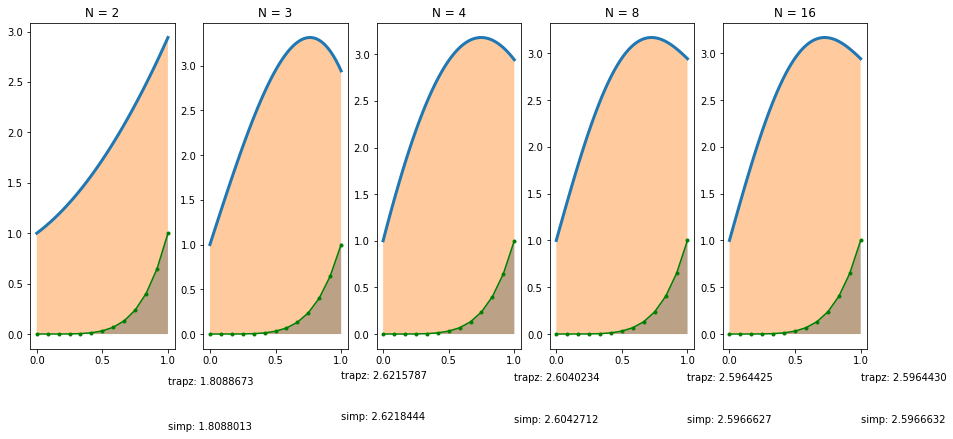

In [13]:
#x = np.linspace(xrange[0], xrange[1], 40)
#y = func3(x)

npoints = [2,3,4,8,16]
fig,axes = plt.subplots(1,len(npoints),figsize=[15,6])

for indx,npoints in enumerate(npoints):
    
    axes[indx].plot(x,y,'g.-')
    axes[indx].fill_between(x, 0, y, alpha=0.5)
    x1 = np.linspace( x[0], x[-1], npoints)
    y1 = func3(x1)
    coeff = np.polyfit(x1,y1,npoints)
    x2 = np.linspace( x[0], x[-1], 50)
    y2 = np.polyval(coeff,x2)
    midpt = np.sum( (y2[1:]+y2[0:-1]) * (x2[1:]-x2[0:-1]) )/2.0
    axes[indx].plot(x2,y2,lw=3)
    axes[indx].fill_between(x2,0,y2,alpha=0.4)
    axes[indx].set_title( 'N = '+ str(npoints) )
    axes[indx].text(1, -0.5, 'trapz: '+ str(scipy.integrate.cumtrapz(y2,x2)[-1])[0:9] )
    axes[indx].text(1, -0.95, 'simp: '+ str(scipy.integrate.simps(y2,x2))[0:9] )

Text(0,0.5,'absolute error')

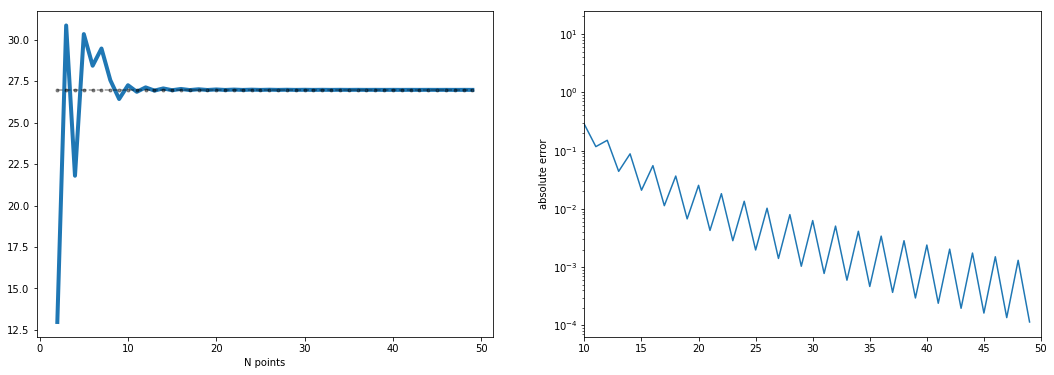

In [14]:
fig, axes = plt.subplots(1,2, figsize=(18,6))

nstack = np.arange(2,50)
istack = []
for npoints in nstack:
    xn = np.linspace(-1.0, 6.0, npoints)
    yn = func3(xn)
    istack.append( scipy.integrate.simps(yn, xn))
istack = np.array(istack)
axes[0].plot(nstack, istack, lw=4)
axes[0].plot(nstack, istack*0+quad_integral, '.k--', alpha=0.4)
axes[0].set_xlabel('N points')
#axes[0].set_ylabel()
axes[1].plot(nstack, np.abs(istack- quad_integral) )
axes[1].set_xlim(10,50)
axes[1].set_yscale('log')
axes[1].set_ylabel('absolute error')

In [15]:
romb_integral = scipy.integrate.romberg( func3, xrange[0], xrange[1], show=True)

Romberg integration of <function vectorize1.<locals>.vfunc at 0x0000026D4BA08840> from [-1.0, 6.0]

 Steps  StepSize   Results
     1  7.000000 12.977625 
     2  3.500000 26.396812 30.869875 
     4  1.750000 29.360833 30.348840 30.314104 
     8  0.875000 27.163934 26.431634 26.170487 26.104715 
    16  0.437500 27.019903 26.971893 27.007910 27.021203 27.024797 
    32  0.218750 26.991951 26.982633 26.983349 26.982959 26.982809 26.982768 
    64  0.109375 26.985383 26.983194 26.983232 26.983230 26.983231 26.983231 26.983232 
   128  0.054688 26.983767 26.983228 26.983230 26.983230 26.983230 26.983230 26.983230 26.983230 
   256  0.027344 26.983364 26.983230 26.983230 26.983230 26.983230 26.983230 26.983230 26.983230 26.983230 

The final result is 26.983230265051965 after 257 function evaluations.


In [16]:
print(quad_integral -  romb_integral)

-1.4210854715202004e-13


In [17]:
%timeit romb_integral = scipy.integrate.romberg( func3, xrange[0], xrange[1], vec_func=False)
%timeit romb_integral = scipy.integrate.romberg( func3, xrange[0], xrange[1], vec_func=True)

#686 µs ± 1.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
#141 µs ± 4.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

910 µs ± 18.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
198 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# PHYS381  Assignment \#3
## Due Sunday Feb 11

### Use scipy.integrate.romberg to evaluate the triple integral

  $$ \int_{x=0}^1 \int_{y=0}^\sqrt{1-x^2} \int_{z=0}^\sqrt{1-x^2-y^2} \frac{dz \, dy \, dx}{1 + x^2 + y^2 + z^2} $$
  
Try to obtain results for a range of precision eg. tol=1e-3, 1e-4, ...
See how small you can make the tolerance and still obtain a result in under a minute or so.
(It may be helpful to adjust divmax.)

Determine the number of calls $N$ to the integrand

  $$ \frac{1}{1 + x^2 + y^2 + z^2} $$
  
required for each value of tol.  Plot the graph of N versus tol and discuss the result.


### A transformation from Cartesian to spherical coordinates changes the integral into the following form

$$ \int_{\theta=0}^{\pi/2} \int_{\phi=0}^{\pi/2} \int_{\rho=0}^1 \frac{\rho^2 \sin\phi \, d\rho \, d\phi \, d\theta}{1 + \rho^2} $$

Apply the same methods as in the previous section to evaluate the triple integral in spherical coordinates.  Compare and discuss your results.


<hr>